In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic', epsilon=1e-4,
                 track_history=False):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.epsilon = epsilon
        self.track_history = track_history
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1  # Last feature as output
        self.control_x = [np.linspace(X[:, m].min(), X[:, m].max(), self.n_control_points)
                         for m in range(n_features)]
        self.control_y = [np.random.uniform(-0.1, 0.1, self.n_control_points)
                         for m in range(n_features)]
        self.initial_control_x = [cx.copy() for cx in self.control_x]
        self.initial_control_y = [cy.copy() for cy in self.control_y]

    def _fit_spline(self):
        self.splines = [CubicSpline(self.control_x[m], self.control_y[m], bc_type='natural')
                       if self.spline_type == 'cubic'
                       else PchipInterpolator(self.control_x[m], self.control_y[m])
                       for m in range(len(self.control_x))]

    def _calculate_displacement(self, X):
        f_x = np.sum([self.splines[m](X[:, m]) for m in range(len(self.splines))], axis=0)
        return X[:, -1] - f_x

    def _update_pseudo_labels(self, X, y):
        f_m1 = sum(self.splines[m](self.m1[m]) for m in range(len(self.splines)))
        displacement_m1 = self.m1[-1] - f_m1
        self.class_1_pseudo = 1 if displacement_m1 > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _compute_gradients(self, X, y):
        displacements = self._calculate_displacement(X)
        pseudo_labels = self._update_pseudo_labels(X, y)
        errors = displacements * pseudo_labels <= 0
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            return [np.zeros(self.n_control_points) for _ in range(len(self.splines))]

        X_err = X[error_indices]
        pseudo_labels_err = pseudo_labels[error_indices]
        grad_y = [np.zeros(self.n_control_points) for _ in range(len(self.splines))]

        for m in range(len(self.splines)):
            base_spline_m = self.splines[m](X_err[:, m])
            perturbed_diff_y_m = np.zeros((self.n_control_points, len(error_indices)))

            for j in range(self.n_control_points):
                control_y_pert = self.control_y[m].copy()
                control_y_pert[j] += self.epsilon
                spline_pert = (CubicSpline(self.control_x[m], control_y_pert, bc_type='natural')
                              if self.spline_type == 'cubic'
                              else PchipInterpolator(self.control_x[m], control_y_pert))
                perturbed_diff_y_m[j] = spline_pert(X_err[:, m]) - base_spline_m

            grad_y[m] += np.dot(pseudo_labels_err, perturbed_diff_y_m.T) / self.epsilon

            # Regularization for smoothness
            diff = self.control_y[m][1:] - self.control_y[m][:-1]
            grad_y[m][1:] += 2 * self.lambda_reg * diff
            grad_y[m][:-1] -= 2 * self.lambda_reg * diff

        return grad_y

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("Data must have at least 2 features")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        current_lr = self.initial_learning_rate
        best_error = float('inf')
        best_control_y = [cy.copy() for cy in self.control_y]
        patience_counter = 0

        if self.track_history:
            self.error_history_ = []
            self.control_point_history = [(self.control_x.copy(), [cy.copy() for cy in self.control_y])]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            error_count = np.sum(displacements * pseudo_labels <= 0)

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_y = [cy.copy() for cy in self.control_y]
                self.class_1_pseudo_best = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_lr = max(current_lr * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_lr == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if self.track_history:
                self.error_history_.append(error_count)
                self.control_point_history.append((self.control_x.copy(), [cy.copy() for cy in self.control_y]))

            grad_y = self._compute_gradients(X, y)
            for m in range(len(self.splines)):
                self.control_y[m] -= current_lr * grad_y[m]
            self._fit_spline()

        self.control_y = best_control_y
        self.class_1_pseudo = self.class_1_pseudo_best
        self._fit_spline()
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

In [3]:
class ClassifierComparison:
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        # We won't create a single split upfront anymore
        # but will keep track of class distribution for reference
        self.grids = {
            'smpa': {
                'learning_rate': [0.01, 0.05, 0.1],           # Range to balance step size
                'epochs': [250],                         # Enough iterations to converge
                'lambda_reg': [1e-5, 1e-3],            # Vary regularization to control smoothness
                'n_control_points': [8, 9],              # More points to capture wiggles
                'spline_type': ['pchip'],            # Test both spline types
                'epsilon': [1e-4, 1.e-2, 1.e-3, 1e-5],                      # Gradient sensitivity
                'patience': [15],                             # Fixed patience for consistency
                'decay_factor': [0.9, 0.99],                        # Fixed decay for simplicity
                'min_learning_rate': [1.e-6]                  # Fixed min LR
            },
            'svm': {
                'C': [0.1, 1, 10, 50, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
            },
            'rf': {
                'n_estimators': [100, 200, 400],
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5]
            },
            'dt': {
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5]
            }
        }
        # Define scaler types but don't fit them yet
        self.scaler_types = {
            'smpa': MinMaxScaler(feature_range=(-100, 100)),
            'svm': StandardScaler(),
            'rf': StandardScaler(),
            'dt': StandardScaler()
        }

    def create_train_test_split(self, seed):
        """Create a fresh train-test split with the given random seed"""
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=seed, stratify=self.y
        )
        print(f"Train Class Dist - {np.bincount(y_train.astype(int))}")
        print(f"Test Class Dist - {np.bincount(y_test.astype(int))}")
        return X_train, X_test, y_train, y_test

    def scale_data(self, X_train, X_test, classifier_type):
        """Scale data using a fresh scaler for the given classifier type"""
        # Create a new scaler instance of the appropriate type
        scaler = self.scaler_types[classifier_type].__class__(**self.scaler_types[classifier_type].get_params())
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def grid_search(self, X_train_scaled, y_train, classifier_type='smpa', seed=0):
        """Perform grid search with the provided scaled training data"""
        classifiers = {
            'smpa': GradientSMPA(random_state=seed, track_history=True),
            'svm': SVC(random_state=seed),
            'rf': RandomForestClassifier(random_state=seed),
            'dt': DecisionTreeClassifier(random_state=seed),
        }
        clf = classifiers[classifier_type]
        param_grid = self.grids[classifier_type]
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
        grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        return grid_search

    def stability_test(self, classifier_type='smpa', n_runs=50):
        scores = []
        best_params_list = []

        for seed in range(n_runs):
            print(f"\nRun {seed} for {classifier_type}...")

            # Create a fresh train-test split for each run
            X_train, X_test, y_train, y_test = self.create_train_test_split(seed)

            # Scale the data for this specific split
            X_train_scaled, X_test_scaled = self.scale_data(X_train, X_test, classifier_type)

            # Grid search on this fresh train split with newly scaled data
            grid_search = self.grid_search(X_train_scaled, y_train, classifier_type, seed)
            clf = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            print(f"Run {seed} Best Params: {grid_search.best_params_}")

            try:
                y_pred = clf.predict(X_test_scaled)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
                if classifier_type == 'smpa':
                    clf.plot_convergence()
                    plt.show()
                print(f"Run {seed} Score: {score:.4f}")
            except Exception as e:
                print(f"🚨 Error in run {seed}: {e}")
                scores.append(0)

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'scores': scores,
            'best_params_list': best_params_list
        }

    def statistical_significance_test(self, baseline_scores_dict, target='smpa'):
        target_scores = baseline_scores_dict[target]['scores']
        for clf_type, results in baseline_scores_dict.items():
            if clf_type != target:
                t_stat, p_val = stats.ttest_ind(target_scores, results['scores'])
                print(f"\n🔬 {target} vs. {clf_type}:")
                print(f"T-Statistic: {t_stat:.4f}")
                print(f"P-Value: {p_val:.4f}")
                print("🏆 Significant difference!" if p_val < 0.05 else "🤝 No significant difference.")

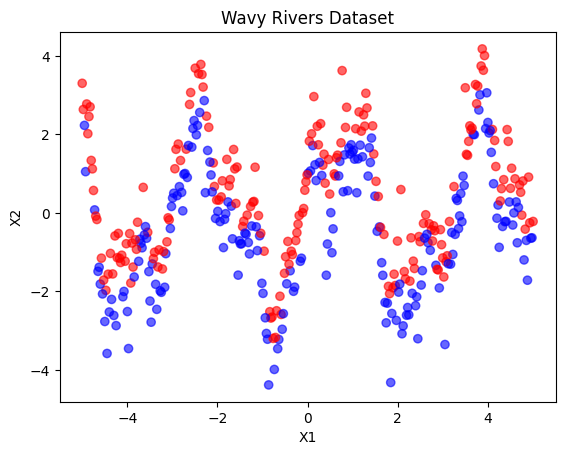


Run 0 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 0 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.0001, 'lambda_reg': 1e-05, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


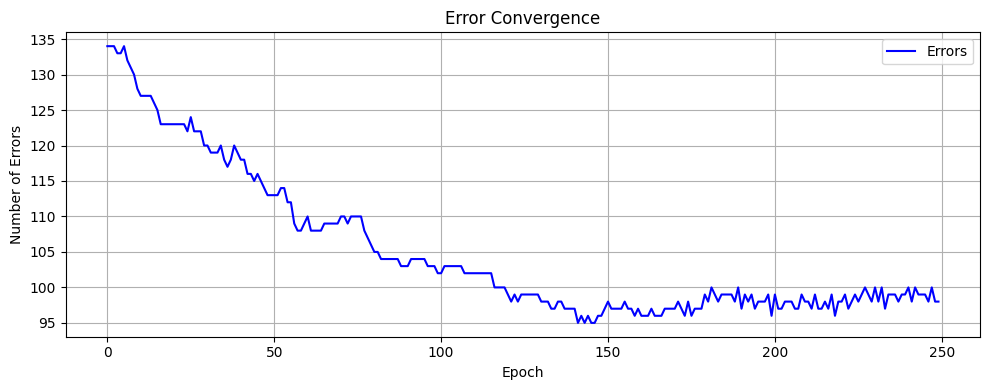

Run 0 Score: 0.7000

Run 1 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 1 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.0001, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 8, 'patience': 15, 'spline_type': 'pchip'}


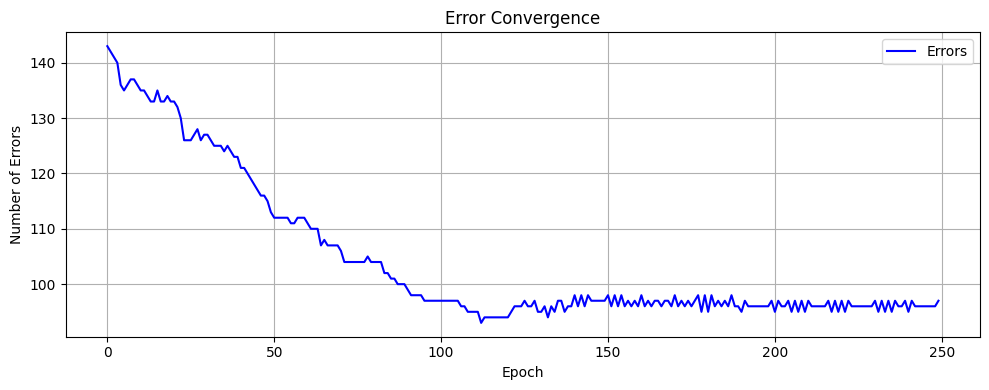

Run 1 Score: 0.6750

Run 2 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 2 Best Params: {'decay_factor': 0.9, 'epochs': 250, 'epsilon': 1e-05, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


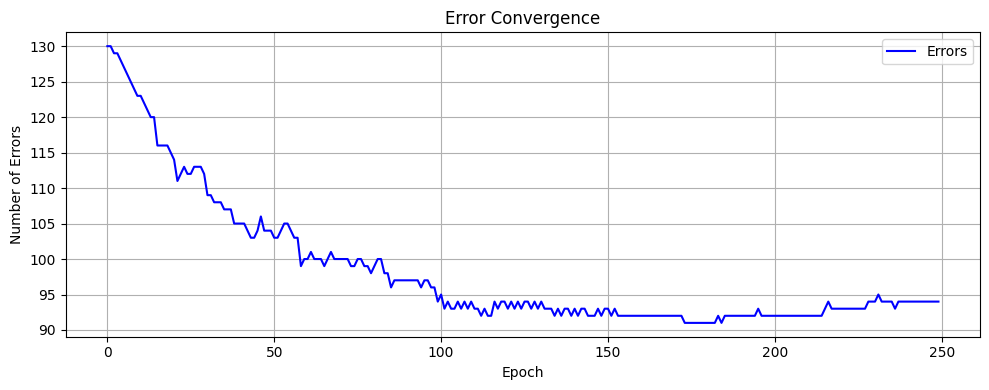

Run 2 Score: 0.5750

Run 3 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 3 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.0001, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


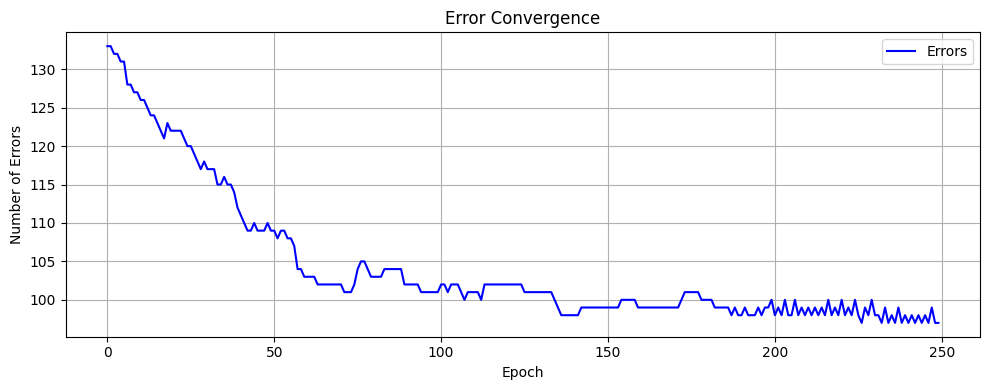

Run 3 Score: 0.6625

Run 4 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 4 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.0001, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 8, 'patience': 15, 'spline_type': 'pchip'}


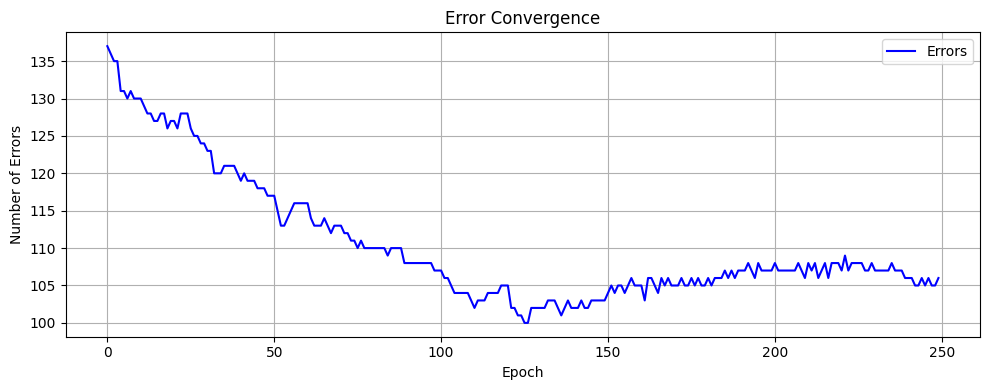

Run 4 Score: 0.7250

Run 5 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 5 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.0001, 'lambda_reg': 1e-05, 'learning_rate': 0.1, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


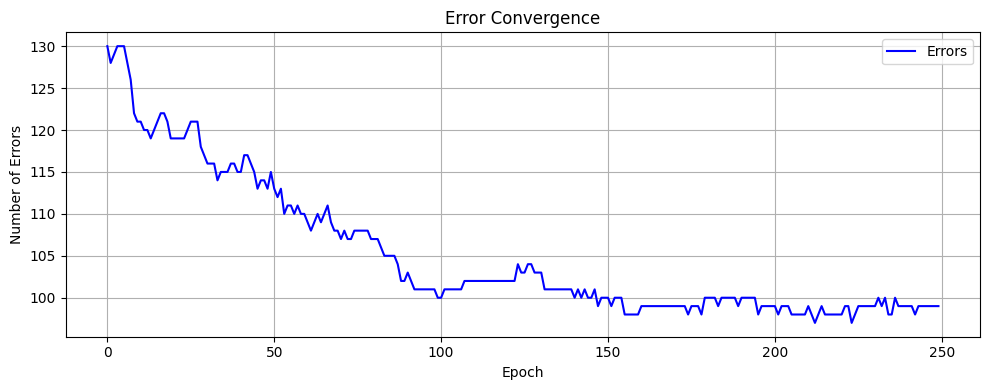

Run 5 Score: 0.7000

Run 6 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 6 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.001, 'lambda_reg': 1e-05, 'learning_rate': 0.05, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


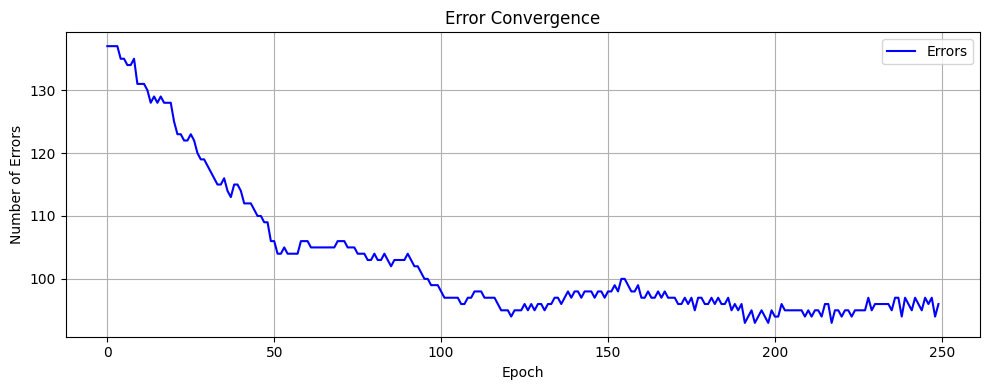

Run 6 Score: 0.6750

Run 7 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 7 Best Params: {'decay_factor': 0.9, 'epochs': 250, 'epsilon': 0.001, 'lambda_reg': 1e-05, 'learning_rate': 0.05, 'min_learning_rate': 1e-06, 'n_control_points': 8, 'patience': 15, 'spline_type': 'pchip'}


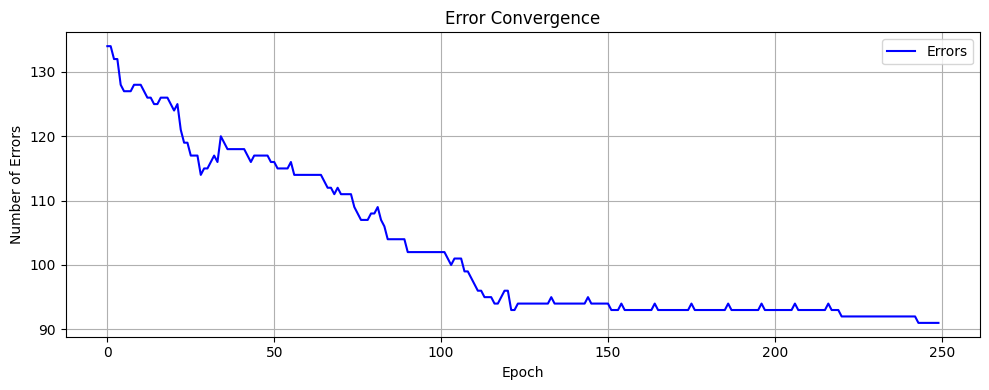

Run 7 Score: 0.6625

Run 8 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 8 Best Params: {'decay_factor': 0.9, 'epochs': 250, 'epsilon': 0.0001, 'lambda_reg': 1e-05, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


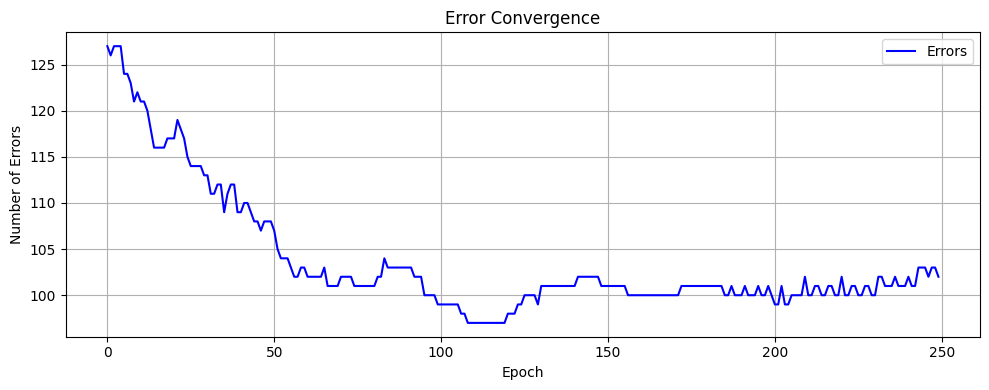

Run 8 Score: 0.6500

Run 9 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Run 9 Best Params: {'decay_factor': 0.99, 'epochs': 250, 'epsilon': 0.01, 'lambda_reg': 1e-05, 'learning_rate': 0.05, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 15, 'spline_type': 'pchip'}


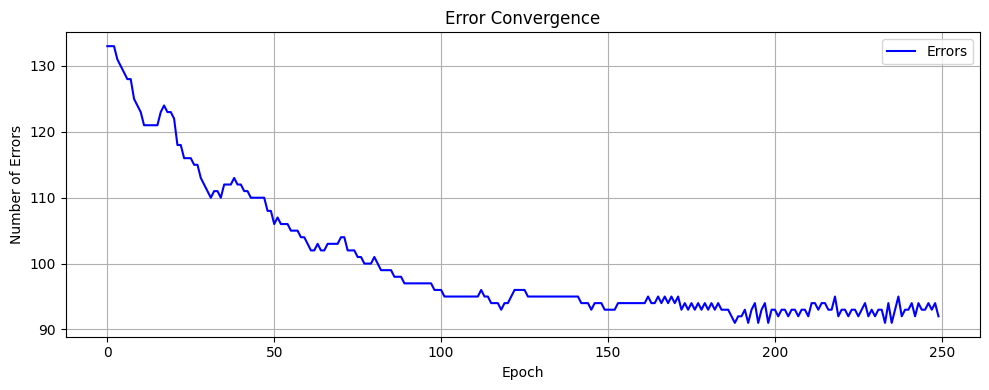

Run 9 Score: 0.6625

Run 0 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Run 0 Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Run 0 Score: 0.6375

Run 1 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Run 1 Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Run 1 Score: 0.6250

Run 2 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Run 2 Best Params: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Run 2 Score: 0.6375

Run 3 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Run 3 Best Params: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Run 3 Score: 0.6375

Run 4 for svm...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wavy_rivers(n_samples=400, noise=0.2, random_state=7):
    """
    Generate a 2D dataset with two classes separated by a squiggly, single-valued boundary.

    Parameters:
    - n_samples: Total number of points (split evenly between classes)
    - noise: Amount of random perturbation
    - random_state: Seed for reproducibility

    Returns:
    - X: 2D array of shape (n_samples, 2)
    - y: Labels array of shape (n_samples,)
    """
    np.random.seed(random_state)
    n_per_class = n_samples // 2

    # Generate x values
    x = np.linspace(-5, 5, n_samples)
    np.random.shuffle(x)
    x_class0 = x[:n_per_class]
    x_class1 = x[n_per_class:]

    # Define a squiggly boundary function (single-valued)
    boundary = (np.sin(2 * x) + 0.5 * np.cos(5 * x) + 0.3 * np.sin(10 * x)) * 2

    # Class 0: Points below the boundary with noise
    y_class0 = boundary[:n_per_class] - np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Class 1: Points above the boundary with noise
    y_class1 = boundary[n_per_class:] + np.abs(np.random.normal(0, noise + 0.5, n_per_class))

    # Combine into dataset
    X = np.vstack([
        np.column_stack([x_class0, y_class0]),
        np.column_stack([x_class1, y_class1])
    ])
    y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])

    # Shuffle
    perm = np.random.permutation(n_samples)
    X = X[perm]
    y = y[perm]

    return X, y

# Test it
X, y = generate_wavy_rivers(n_samples=400, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Wavy Rivers Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

comparison = ClassifierComparison(X, y)

# Run all classifiers on same split
classifiers = ['smpa', 'svm', 'rf', 'dt']
results = {}
for clf_type in classifiers:
    results[clf_type] = comparison.stability_test(clf_type, n_runs=10)

for clf_type, res in results.items():
    print(f"\n📊 {clf_type.upper()} Stability:")
    print(f"Mean Score: {res['mean_score']:.4f}")
    print(f"Score Std Dev: {res['std_score']:.4f}")

comparison.statistical_significance_test(results, target='smpa')